<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_GAN/blob/master/generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Conv2D, Dense, BatchNormalization, Flatten, LeakyReLU, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras import Sequential, optimizers, metrics

import matplotlib.pyplot as plt

import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

In [134]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

In [135]:
x_train.shape[0]

60000

In [136]:
batch_size = 256
noise_dim = 100
lr = 1e-4

In [137]:
train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(x_train.shape[0]).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices(x_test).shuffle(x_test.shape[0]).batch(batch_size)
train_data

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

generator = Generator(gen_net=gen_net, noise=noise, optimizer=optimizer)

In [138]:
class GAN(keras.Model):

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.generator = Sequential(self.gen_nn)
        self.discriminator = Sequential(self.dis_nn)
        self.cross_entropy = self.cross_entropy
        self.noise_z = self.noise

    def Generator(self, x):
        return self.generator(x)

    def Discriminator(self, x):
        return self.discriminator(x)

    @tf.function
    def dis_loss(self, real_output, fake_output):
        # total_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1-fake_output))

        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    @tf.function
    def gen_loss(self, fake_output):
        # loss = -tf.reduce_mean(tf.math.log(fake_output))
        
        loss = self.cross_entropy(tf.ones_like(fake_output), fake_output)
        return loss

        
    @tf.function
    def compute_gradient(self, x):
        noise = self.noise_z

        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            generated_img = self.Generator(noise)

            real_output = self.Discriminator(x)
            fake_output = self.Discriminator(generated_img)

            loss_gen = self.gen_loss(fake_output)
            loss_dis = self.dis_loss(real_output, fake_output)

        gradient_gen = gen_tape.gradient(loss_gen, self.generator.trainable_variables)
        gradient_dis = dis_tape.gradient(loss_dis, self.discriminator.trainable_variables)

        return gradient_gen, gradient_dis, loss_gen, loss_dis

    @tf.function
    def train(self, x):
        gradient_gen, gradient_dis, loss_gen, loss_dis = self.compute_gradient(x)
        self.gen_optimizer.apply_gradients(zip(gradient_gen, self.generator.trainable_variables))
        self.dis_optimizer.apply_gradients(zip(gradient_dis, self.discriminator.trainable_variables))
        return loss_gen, loss_dis



In [139]:
gen_nn = [Dense(7*7*256, input_shape=(100,)),
          BatchNormalization(),
          LeakyReLU(),
          
          Reshape((7,7,256)),
          Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
          BatchNormalization(),
          LeakyReLU(),
          Dropout(0.3),
          
          Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
          BatchNormalization(),
          LeakyReLU(),
          Dropout(0.3),
          
          Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')]

dis_nn = [Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
          LeakyReLU(),
          Dropout(0.3),
          
          Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
          LeakyReLU(),
          Dropout(0.3),
          
          Flatten(),
          Dense(1)]

optimizer = optimizers.Adam(learning_rate=lr)
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
noise = tf.random.normal([batch_size, noise_dim])

In [140]:
gen_network = GAN(gen_nn=gen_nn, 
                  dis_nn=dis_nn, 
                  noise=noise, 
                  gen_optimizer=optimizer, 
                  dis_optimizer=optimizer, 
                  cross_entropy=cross_entropy)

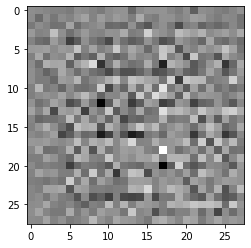

In [141]:
# geerate random noise img
noise_ = tf.random.normal([1, 100])
generated_img = gen_network.Generator(noise_)
plt.imshow(generated_img[0, :, :, 0], cmap='gray')


In [142]:
decision = gen_network.Discriminator(generated_img)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0010838]], dtype=float32)>

In [143]:
train_gen_loss = metrics.Mean(name='train_generator_loss')
train_dis_loss = metrics.Mean(name='train_discriminator_loss')
test_gen_loss = metrics.Mean(name='test_generator_loss')
test_dis_loss = metrics.Mean(name='test_discriminator_loss')

In [144]:
import time
display_step = 5

strat_time = time.time()
for epoch in range(50):
    for x_batch in train_data:
        gen_loss, dis_loss = gen_network.train(x_batch)
        train_gen_loss(gen_loss)
        train_dis_loss(dis_loss)

    for x_batch in test_data:
        a,b, loss_gen_t, loss_dis_t = gen_network.compute_gradient(x_batch)
        test_gen_loss(loss_gen_t)
        test_dis_loss(loss_dis_t)

    print(f'Epoch: {epoch}, Gen[train]: {train_gen_loss.result()}, Dis[train]: {train_dis_loss.result()}, Gen[test]: {test_gen_loss.result()}, Dis[test]: {test_dis_loss.result()} ')

    if epoch % display_step == 0 or epoch == (9):
        print('display')
        print(f'time: {time.time() - strat_time} ')

    train_gen_loss.reset_states()
    train_dis_loss.reset_states()
    test_gen_loss.reset_states()
    test_dis_loss.reset_states()

Epoch: 0, Gen[train]: 1.0945178270339966, Dis[train]: 1.0859788656234741, Gen[test]: 0.6996899843215942, Dis[test]: 1.333933711051941 
display
time: 10.131375074386597 
Epoch: 1, Gen[train]: 0.6989730000495911, Dis[train]: 1.373388648033142, Gen[test]: 0.7684177160263062, Dis[test]: 1.360479712486267 
Epoch: 2, Gen[train]: 0.7769612669944763, Dis[train]: 1.2817269563674927, Gen[test]: 0.7335605025291443, Dis[test]: 1.2394635677337646 
Epoch: 3, Gen[train]: 0.7679622769355774, Dis[train]: 1.2709323167800903, Gen[test]: 0.775357723236084, Dis[test]: 1.3576656579971313 
Epoch: 4, Gen[train]: 0.8273834586143494, Dis[train]: 1.2160924673080444, Gen[test]: 0.6772657036781311, Dis[test]: 1.293562412261963 
Epoch: 5, Gen[train]: 0.8960031270980835, Dis[train]: 1.1121132373809814, Gen[test]: 0.9056054353713989, Dis[test]: 1.0671296119689941 
display
time: 45.39218473434448 
Epoch: 6, Gen[train]: 0.9781966805458069, Dis[train]: 1.0200294256210327, Gen[test]: 0.8932216763496399, Dis[test]: 1.1012